In [121]:
#! /usr/bin/env python3
'''===============================================================================================================
 - Author: M. Guesmi
 - Adress: Chair of process engineering TU Dresden, George-Bähr-Straße 3b, 01069 Dresden, Germany
 - Summary: test different machine learning models to classfiy flow pattern based on operational and geometrical features 
=================================================================================================================='''

'===============================================================================================================\n - Author: M. Guesmi\n - Adress: Chair of process engineering TU Dresden, George-Bähr-Straße 3b, 01069 Dresden, Germany\n - Summary: test different machine learning models to classfiy flow pattern based on operational and geometrical features \n=================================================================================================================='

In [122]:
# 
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
#from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from scipy import stats


# ML-Models
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
# Grid search
from sklearn.model_selection import GridSearchCV
# Evaluation metrics
from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
# 
from sklearn.feature_selection import mutual_info_classif


# Create a DataFrame for easier plotting

from sklearn.preprocessing import LabelBinarizer
import pickle
# Output, Display
from tabulate import tabulate
from IPython.display import display, HTML
# import joblib to import model to file
import joblib

In [123]:
# Use LaTeX and set the default font to Computer Modern Roman
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

In [124]:
import warnings


warnings.filterwarnings("ignore", category=FutureWarning)
# Ignore the UserWarning
warnings.filterwarnings("ignore", category=UserWarning)


# Ignore all warnings
#warnings.filterwarnings('ignore')

In [125]:
df = pd.read_csv('training_test_data.csv',sep=',')

In [126]:
df.describe()

,Vsl,Vsg,DenL,DenG,VisL,VisG,ST,ID,Ang,Flow_label
count,3523.000000,3523.000000,3523.000000,3523.000000,3523.000000,3.523000e+03,3523.000000,3523.000000,3523.000000,3523.000000
mean,0.902791,6.836029,963.239290,3.705230,0.012039,1.317070e-05,0.065915,0.046693,0.333272,2.458132
std,1.351430,13.410838,146.653889,6.519686,0.071802,4.577323e-06,0.013631,0.025207,4.193035,1.035510
min,0.000241,0.014967,77.041602,0.125000,0.000012,5.070000e-07,0.015000,0.008740,-10.000000,0.000000
25%,0.033713,0.400000,1000.000000,1.180000,0.001000,1.500000e-05,0.070000,0.025000,0.000000,2.000000
50%,0.250000,1.969150,1000.000000,1.180000,0.001000,1.500000e-05,0.070000,0.051000,0.250000,3.000000
75%,1.012195,10.000000,1000.000000,1.180000,0.001000,1.500000e-05,0.070000,0.051000,1.030000,3.000000
max,6.475590,200.609756,1000.000000,26.900000,0.483000,1.900000e-05,0.070000,0.106400,10.000000,4.000000


Correlation between Vsl and Flow Pattern: 0.5659112402624235
Correlation between Vsg and Flow Pattern: -0.12885307242413216
Correlation between DenL and Flow Pattern: -0.019858160134815034
Correlation between DenG and Flow Pattern: 0.1333701306814368
Correlation between VisL and Flow Pattern: 0.0026341204959098126
Correlation between VisG and Flow Pattern: -0.12990230323786767
Correlation between ID and Flow Pattern: 0.1357908180811833
Correlation between Ang and Flow Pattern: 0.27219734378163346


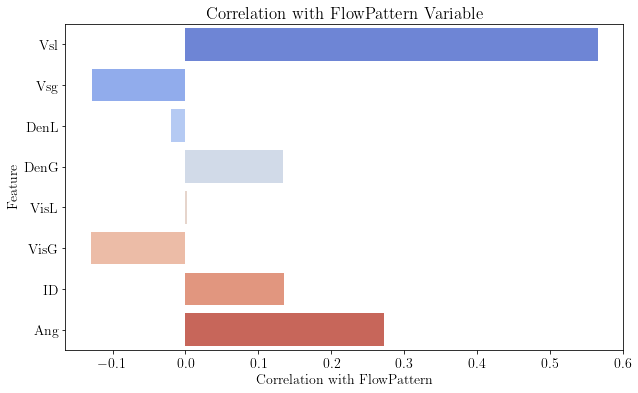

In [127]:
# Calculate the correlation between each feature and the Flow pattern
correlation_df = pd.DataFrame(columns=['Feature', 'Correlation with FlowPattern'])

#for feature in df.drop(columns=['Author', 'Flow_label']).columns:
for feature in df.drop(columns=['Author', 'ST','Flow_label']).columns:
    #correlation    = df[feature].corr(df['Flow_label'])
    correlation = df[feature].corr(df['Flow_label'])
    print(f"Correlation between {feature} and Flow Pattern: {correlation}")
    correlation_df = pd.concat([correlation_df, pd.DataFrame({'Feature': [feature], 'Correlation with FlowPattern': [correlation]})], ignore_index=True)

# Generate a bar plot to visualize the correlation with the Flow pattern
plt.figure(figsize=(10, 6))
sns.barplot(x='Correlation with FlowPattern', y='Feature', data=correlation_df, palette='coolwarm')
plt.title('Correlation with FlowPattern Variable')
plt.show()

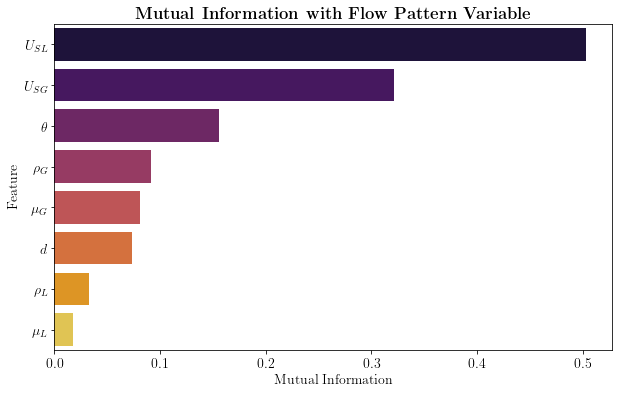

In [128]:

# Assuming df is your DataFrame and 'Flow_label' is your target variable
X = df.drop(columns=['Author', 'ST', 'Flow_label'])
y = df['Flow_label']

# Calculate Mutual Information
mi_scores = mutual_info_classif(X, y)

# Create a DataFrame for easier plotting
mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mi_scores})

# Sort the DataFrame by Mutual Information scores
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)

# Create a dictionary that maps the original feature names to their LaTeX-style labels
latex_labels = {
    'Vsl': r'$U_{SL}$',
    'Vsg': r'$U_{SG}$',
    'DenL': r'$\rho_L$',
    'DenG': r'$\rho_G$',
    'VisL': r'$\mu_L$',
    'VisG': r'$\mu_G$',
    'ST': r'$ST$',
    'ID': r'$d$',
    'Ang': r'$\theta$',
    'Flow_label': r'$Flow\_label$'
}

# Replace the feature names with their LaTeX-style labels
mi_df['Feature'] = mi_df['Feature'].map(latex_labels)
# Set the font size
plt.rcParams['font.size'] = 14
# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Mutual Information', y='Feature', data=mi_df, palette='inferno')
plt.title(r'\textbf{Mutual Information with Flow Pattern Variable}')
plt.show()

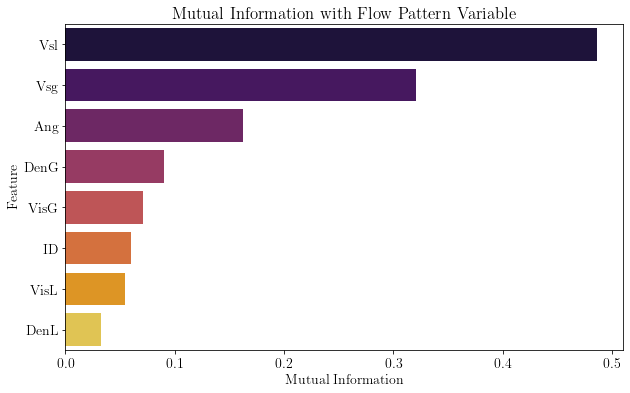

In [129]:
# Assuming df is your DataFrame and 'Flow_label' is your target variable
# Prepare your features and target variable
X = df.drop(columns=['Author', 'ST', 'Flow_label'])
# consider the effect of ST
#X = df.drop(columns=['Author', 'Flow_label'])
y = df['Flow_label']

# Calculate Mutual Information
mi_scores = mutual_info_classif(X, y)

# Create a DataFrame for easier plotting
mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mi_scores})

# Sort the DataFrame by Mutual Information scores
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)
# Set the font size
plt.rcParams['font.size'] = 14
# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Mutual Information', y='Feature', data=mi_df, palette='inferno')
plt.title('Mutual Information with Flow Pattern Variable')
plt.show()

In [130]:
# Define the random state
random_state = 42

In [131]:
# Split the dataset into train and test sets
# Features
X = df.drop(columns=['Author', 'ST','Flow_label'], axis=1) 
# consider ST effect    
#X = df.drop(columns=['Author','Flow_label'], axis=1) 
# Target variable
y = df['Flow_label']                          
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
train_data = pd.concat([X_train, y_train], axis=1)
print('everything is fine sofar!')

everything is fine sofar!


In [132]:
# Hyperparameter tuning with GridSearchCV of SVC model

# Define the parameter grid, including kernel and max_iter
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf'],  # Add different kernels you want to test
    'max_iter': [1000, 5000, 20000]  # Add different max_iter values
}

# Initialize SVC (no need to define kernel and max_iter here as they're in param_grid)
svc_classifier = SVC()

# Initialize GridSearchCV
grid_search_svc = GridSearchCV(svc_classifier, param_grid, cv=5, n_jobs=-1)

# Fit the model on the training data
grid_search_svc.fit(X_train, y_train)

# Get the best parameters
best_params_svc = grid_search_svc.best_params_
# Get the best score
best_score_svc = grid_search_svc.best_score_
#print
print(f"SVC-Best parameters: {best_params_svc}")
print(f"SVC-Best score: {best_score_svc}")

# Hyperparameter tuning with GridSearchCV of Decision Tree   

# Define the parameter grid for Decision Tree
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=random_state)

# Initialize GridSearchCV
grid_search_dt = GridSearchCV(dt_classifier, param_grid_dt, cv=5, n_jobs=-1)

# Fit the model on the training data
grid_search_dt.fit(X_train, y_train)

# Get the best parameters and best score
best_params_dt = grid_search_dt.best_params_
best_score_dt = grid_search_dt.best_score_

print(f"Decision Tree - Best parameters: {best_params_dt}")
print(f"Decision Tree - Best score: {best_score_dt}")

# Hyperparameter tuning with GridSearchCV of Random Forest
# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [10, 50, 100, 200],
    'max_features': ['sqrt', 'log2', None],  # Remove 'auto'
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Random Forest Classifier
rf_classifier = RandomForestClassifier()

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(rf_classifier, param_grid_rf, cv=5, n_jobs=-1, error_score='raise')

# Fit the model on the training data
grid_search_rf.fit(X_train, y_train)

# Get the best parameters and best score
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

print(f"Random Forest - Best parameters: {best_params_rf}")
print(f"Random Forest - Best score: {best_score_rf}")

# Hyperparameter tuning with GridSearchCV of Logistic Regression
# Define the parameter grid for Logistic Regression
param_grid_lr = {
    'C': [0.1, 1, 10, 100],
    'solver': [ 'lbfgs', 'liblinear', 'saga'],
    'max_iter': [100, 200, 300]
}

# Initialize Logistic Regression
lr_classifier = LogisticRegression(random_state=random_state)

# Initialize GridSearchCV with cross-validation
grid_search_lr = GridSearchCV(lr_classifier, param_grid_lr, cv=5, n_jobs=-1)

# Fit the model on the training data
grid_search_lr.fit(X_train, y_train)

# Get the best parameters and best score
best_params_lr = grid_search_lr.best_params_
best_score_lr = grid_search_lr.best_score_

print(f"Logistic Regression - Best parameters: {best_params_lr}")
print(f"Logistic Regression - Best score: {best_score_lr}")

# Hyperparameter tuning with GridSearchCV of XGBoost
# Define the parameter grid for XGBoost
param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize XGBoost Classifier
xgb_classifier = XGBClassifier(random_state=random_state)

# Initialize GridSearchCV with cross-validation
grid_search_xgb = GridSearchCV(xgb_classifier, param_grid_xgb, cv=5, n_jobs=-1)

# Fit the model on the training data
grid_search_xgb.fit(X_train, y_train)

# Get the best parameters and best score
best_params_xgb = grid_search_xgb.best_params_
best_score_xgb = grid_search_xgb.best_score_

print(f"XGBoost - Best parameters: {best_params_xgb}")
print(f"XGBoost - Best score: {best_score_xgb}")

SVC-Best parameters: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf', 'max_iter': 1000}
SVC-Best score: 0.8750721187155941
Decision Tree - Best parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Decision Tree - Best score: 0.9268861091165614
Random Forest - Best parameters: {'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest - Best score: 0.9471152513762393
Logistic Regression - Best parameters: {'C': 100, 'max_iter': 100, 'solver': 'liblinear'}
Logistic Regression - Best score: 0.7022662282856531
XGBoost - Best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
XGBoost - Best score: 0.949955909955532


In [133]:
print(f"XGBoost - Best parameters: {best_params_xgb}")
print(f"XGBoost - Best score: {best_score_xgb}")

print(f"Decision Tree - Best parameters: {best_params_dt}")
print(f"Decision Tree - Best score: {best_score_dt}")

print(f"Random Forest - Best parameters: {best_params_rf}")
print(f"Random Forest - Best score: {best_score_rf}")

print(f"SVC-Best parameters: {best_params_svc}")
print(f"SVC-Best score: {best_score_svc}")

print(f"Logistic Regression - Best parameters: {best_params_lr}")
print(f"Logistic Regression - Best score: {best_score_lr}")

XGBoost - Best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
XGBoost - Best score: 0.949955909955532
Decision Tree - Best parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Decision Tree - Best score: 0.9268861091165614
Random Forest - Best parameters: {'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest - Best score: 0.9471152513762393
SVC-Best parameters: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf', 'max_iter': 1000}
SVC-Best score: 0.8750721187155941
Logistic Regression - Best parameters: {'C': 100, 'max_iter': 100, 'solver': 'liblinear'}
Logistic Regression - Best score: 0.7022662282856531


In [134]:
# Set to True for best parameters, False for standard configuration
use_best_params = True

if(not use_best_params):
    # Initialize  classifiers with standard parameters
    classifiers = {
        'XGBClassifier': XGBClassifier(),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'Logistic Regression': LogisticRegression(max_iter=20000),
        'Support Vector Machine': SVC(kernel='linear', C=0.1, gamma='scale', max_iter=20000)
    }
else:
    # Initialize different classifiers with best parameters
    classifiers = {
        'XGBClassifier': XGBClassifier(**best_params_xgb),
        'Decision Tree': DecisionTreeClassifier(**best_params_dt),
        'Random Forest': RandomForestClassifier(**best_params_rf),
        'Logistic Regression': LogisticRegression(**best_params_lr),
        'Support Vector Machine': SVC(**best_params_svc)
    }

In [135]:
# cross validation 
# Initialize a KFold object with k=5-fold, 10-fold (5-fold cross-validation)
# random_state = 42
n_splits = 5 
kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# Initialize a list to store results
results = []

# Perform k-fold cross-validation for each classifier
for clf_name, clf in classifiers.items():
    cv_scores = []
    
    for train_index, test_index in kf.split(X):
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

        # Train the model on the training data
        clf.fit(X_train_cv, y_train_cv)

        # Make predictions on the test data
        y_pred_cv = clf.predict(X_test_cv)

        # Calculate accuracy and store the score
        accuracy = accuracy_score(y_test_cv, y_pred_cv)
        cv_scores.append(accuracy)
    
    # Calculate average cross-validation score and standard deviation
    average_score = sum(cv_scores) / len(cv_scores) * 100
    std_deviation = np.std(cv_scores) * 100
    
    # Store the result
    results.append([clf_name, f"{average_score:.2f}% ± {std_deviation:.2f}%"])



In [136]:
# Sort results by average score in descending order
results_sorted = sorted(results, key=lambda x: x[1], reverse=True)
# Print the results as a table
print(f'Cross validation for k-fold = {n_splits}:')
print(tabulate(results_sorted, headers=['Classifier', 'Average Score'], tablefmt='pretty'))



Cross validation for k-fold = 5:
+------------------------+----------------+
|       Classifier       | Average Score  |
+------------------------+----------------+
|     Random Forest      | 94.95% ± 0.48% |
|     XGBClassifier      | 94.86% ± 0.52% |
|     Decision Tree      | 93.61% ± 0.79% |
| Support Vector Machine | 87.91% ± 2.02% |
|  Logistic Regression   | 69.88% ± 0.53% |
+------------------------+----------------+


In [137]:
# Initialize a KFold object with k=5-fold, 10-fold (5-fold cross-validation)
# random_state = 42
n_splits = 10 
kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# Initialize a list to store results
results = []

# Perform k-fold cross-validation for each classifier
for clf_name, clf in classifiers.items():
    cv_scores = []
    
    for train_index, test_index in kf.split(X):
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

        # Train the model on the training data
        clf.fit(X_train_cv, y_train_cv)

        # Make predictions on the test data
        y_pred_cv = clf.predict(X_test_cv)

        # Calculate accuracy and store the score
        accuracy = accuracy_score(y_test_cv, y_pred_cv)
        cv_scores.append(accuracy)
    
    # Calculate average cross-validation score and standard deviation
    average_score = sum(cv_scores) / len(cv_scores) * 100
    std_deviation = np.std(cv_scores) * 100
    
    # Store the result
    results.append([clf_name, f"{average_score:.2f}% ± {std_deviation:.2f}%"])



In [138]:
# Sort results by average score in descending order
results_sorted = sorted(results, key=lambda x: x[1], reverse=True)
# Print the results as a table
print(f'Cross validation for k-fold = {n_splits}:')
print(tabulate(results_sorted, headers=['Classifier', 'Average Score ± Std Dev'], tablefmt='pretty'))


Cross validation for k-fold = 10:
+------------------------+-------------------------+
|       Classifier       | Average Score ± Std Dev |
+------------------------+-------------------------+
|     Random Forest      |     95.43% ± 1.30%      |
|     XGBClassifier      |     95.43% ± 1.24%      |
|     Decision Tree      |     94.01% ± 1.09%      |
| Support Vector Machine |     88.45% ± 2.21%      |
|  Logistic Regression   |     69.97% ± 1.55%      |
+------------------------+-------------------------+


In [139]:
# repeated cross validation 
# Parameters
n_splits = 5  # Number of folds
n_repeats = 5  # Number of repetitions
random_state = 42

# Initialize KFold object with n_splits
kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# Initialize a list to store results
results = []

# Perform repeated k-fold cross-validation for each classifier
for clf_name, clf in classifiers.items():
    repeat_scores = []

    for repeat in range(n_repeats):
        cv_scores = []

        for train_index, test_index in kf.split(X):
            X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
            y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

            # Train the model on the training data
            clf.fit(X_train_cv, y_train_cv)

            # Make predictions on the test data
            y_pred_cv = clf.predict(X_test_cv)

            # Calculate accuracy and store the score
            accuracy = accuracy_score(y_test_cv, y_pred_cv)
            cv_scores.append(accuracy)
        
        # Store the mean accuracy for this repetition
        repeat_scores.append(np.mean(cv_scores))

    # Calculate average and standard deviation of cross-validation scores across repetitions
    average_score = np.mean(repeat_scores) * 100
    std_deviation = np.std(repeat_scores) * 100
    
    # Store the result
    results.append([clf_name, f"{average_score:.2f}% ± {std_deviation:.2f}%"])



In [140]:
# Sort results by average score in descending order
results_sorted = sorted(results, key=lambda x: x[1], reverse=True)

# Format and print results
headers = ["Classifier", "Average Score (%)", "Standard Deviation (%)"]
table = tabulate(results_sorted, headers=headers, tablefmt="grid", numalign="center")
print(f"Repeated Cross Validation for k-Fold = {n_splits}:\n{table}")

Repeated Cross Validation for k-Fold = 5:
+------------------------+---------------------+
| Classifier             | Average Score (%)   |
+========================+=====================+
| Random Forest          | 95.08% ± 0.12%      |
+------------------------+---------------------+
| XGBClassifier          | 94.86% ± 0.00%      |
+------------------------+---------------------+
| Decision Tree          | 93.64% ± 0.08%      |
+------------------------+---------------------+
| Support Vector Machine | 87.91% ± 0.00%      |
+------------------------+---------------------+
| Logistic Regression    | 69.88% ± 0.00%      |
+------------------------+---------------------+


In [141]:
# Parameters
n_splits = 5  # Number of folds
n_repeats = 10  # Number of repetitions
random_state = 42

# Initialize KFold object with n_splits
kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# Initialize a list to store results
results = []

# Perform repeated k-fold cross-validation
for clf_name, clf in classifiers.items():
    repeat_scores = []

    for repeat in range(n_repeats):
        cv_scores = []

        for train_index, test_index in kf.split(X):
            X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
            y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

            # Train the model on the training data
            clf.fit(X_train_cv, y_train_cv)

            # Make predictions on the test data
            y_pred_cv = clf.predict(X_test_cv)

            # Calculate accuracy and store the score
            accuracy = accuracy_score(y_test_cv, y_pred_cv)
            cv_scores.append(accuracy)
        
        # Store the mean accuracy for this repetition
        repeat_scores.append(np.mean(cv_scores))

    # Calculate average and standard deviation of scores
    average_score = np.mean(repeat_scores) * 100
    std_deviation = np.std(repeat_scores) * 100
    
    # Calculate 95% confidence intervals
    try:
        print('standard deviation',std_deviation)
        # Only calculate CI if std_deviation is not zero and sample size is sufficient
        if std_deviation > 0 and len(repeat_scores) > 1:
            mean = average_score / 100
            sem = std_deviation / 100 / np.sqrt(len(repeat_scores))
            ci_95 = stats.t.interval(0.95, len(repeat_scores)-1, loc=mean, scale=sem)
            ci_str = f"{ci_95[0]*100:.2f}% - {ci_95[1]*100:.2f}%"
        else:
            ci_str = "N/A"
    except Exception as e:
        ci_str = f"Error: {str(e)}"

    # Store the result
    results.append([
        clf_name,
        f"{average_score:.2f}%",
        f"{std_deviation:.2f}%",
        ci_str
    ])


standard deviation 0.0
standard deviation 0.13161580147467744
standard deviation 0.11828872257804446
standard deviation 0.0
standard deviation 0.0


In [142]:
# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['Classifier', 'Average Accuracy (%)', 'Standard Deviation (%)', '95% CI'])
print("Repeated Cross-Validation Results with 95% Confidence Intervals:")
print(tabulate(results_df, headers='keys', tablefmt='grid', numalign='center'))

Repeated Cross-Validation Results with 95% Confidence Intervals:
+----+------------------------+------------------------+--------------------------+-----------------+
|    | Classifier             | Average Accuracy (%)   | Standard Deviation (%)   | 95% CI          |
+====+========================+========================+==========================+=================+
| 0  | XGBClassifier          | 94.86%                 | 0.00%                    | N/A             |
+----+------------------------+------------------------+--------------------------+-----------------+
| 1  | Decision Tree          | 93.59%                 | 0.13%                    | 93.49% - 93.68% |
+----+------------------------+------------------------+--------------------------+-----------------+
| 2  | Random Forest          | 95.07%                 | 0.12%                    | 94.98% - 95.15% |
+----+------------------------+------------------------+--------------------------+-----------------+
| 3  | Logistic R

In [143]:
# Multiclass accuracy 
# Generate y_pred for each classifier
y_preds = {}
# Initialize a list to store the results of accuracy
results = []
models_accuracies=[]
# Train and evaluate each classifier
for clf_name, clf in classifiers.items():
    # Train the classifier
    clf.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = clf.predict(X_test)
    y_preds[clf_name] = y_pred
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred) * 100  # Multiply by 100 for percentage
    results.append([clf_name, f"{accuracy:.2f}%"])
    models_accuracies.append([clf_name, accuracy])


In [144]:
# Print results as a table
print('Mutliclass accuracy:')
print(tabulate(results, headers=["Model", "Accuracy"], tablefmt="pretty"))

Mutliclass accuracy:
+------------------------+----------+
|         Model          | Accuracy |
+------------------------+----------+
|     XGBClassifier      |  94.33%  |
|     Decision Tree      |  93.48%  |
|     Random Forest      |  94.33%  |
|  Logistic Regression   |  70.35%  |
| Support Vector Machine |  87.94%  |
+------------------------+----------+


In [145]:
# Define original labels and desired labels
original_labels = ['0', '1', '2', '3', '4']
desired_labels = ['SS', 'SW', 'A', 'I', 'DB']
#desired_labels = ['Smooth-Stratified', 'Wavy-Stratified', 'Annular', 'Slug', 'Bubbly']
# Create a dictionary to map original labels to desired labels
label_mapping = {original_labels[i]: desired_labels[i] for i in range(len(original_labels))}



Confusion Matrix:


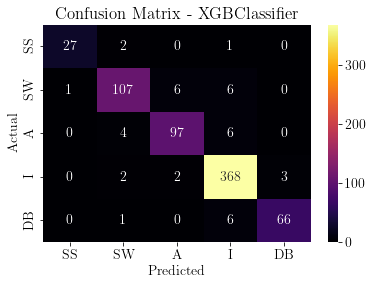

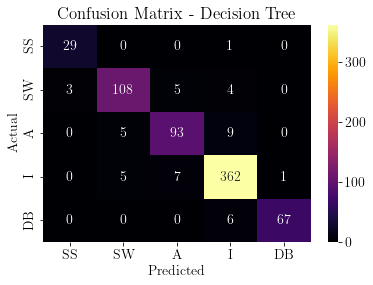

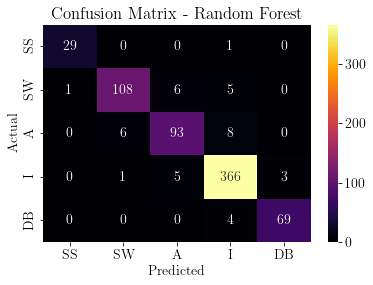

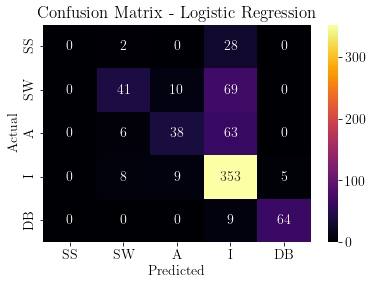

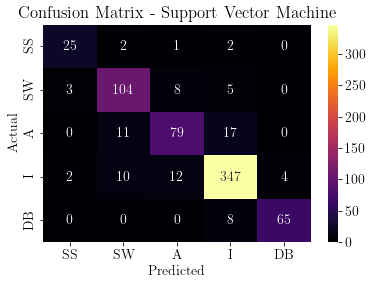

In [146]:
# Initialize a dictionary to store confusion matrices
confusion_matrices = {}

for name, y_pred in y_preds.items():
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices[name] = cm

print('Confusion Matrix:')
# Plot the confusion matrices
for name, cm in confusion_matrices.items():
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='inferno', xticklabels=desired_labels, yticklabels=desired_labels) # Reverse yticklabels
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    # Create the confusion matrix using scikit-learn
    cm = confusion_matrix(y_test, y_pred)
    # Calculate row sums (total predictions for each class)
    row_sums = np.sum(cm, axis=1)
    # Calculate percentages
    percentages = cm / row_sums[:, np.newaxis] * 100  # Ensure division is element-wise
    #sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=desired_labels, yticklabels=desired_labels) # Reverse yticklabels

   

Confusion Matrix:


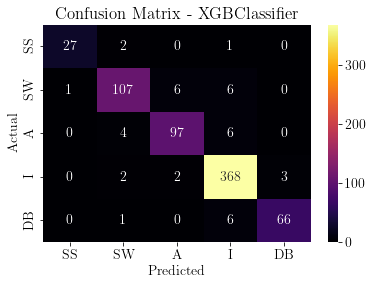

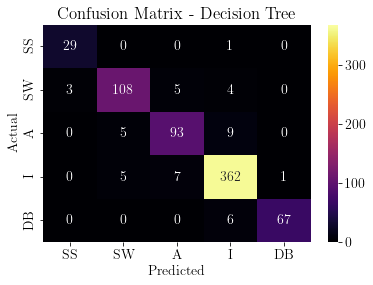

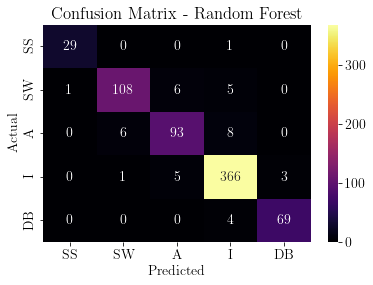

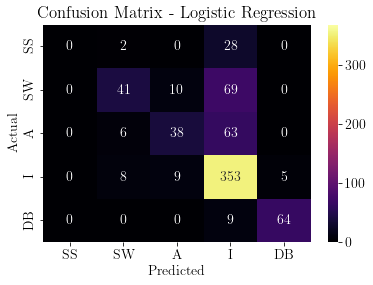

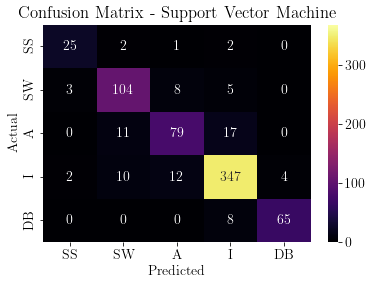

In [147]:
# Initialize a dictionary to store confusion matrices
confusion_matrices = {}

for name, y_pred in y_preds.items():
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices[name] = cm

# Find the maximum value among all confusion matrices
max_value = max(np.max(cm) for cm in confusion_matrices.values())

print('Confusion Matrix:')
# Plot the confusion matrices
for name, cm in confusion_matrices.items():
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='inferno', xticklabels=desired_labels, yticklabels=desired_labels, vmin=0, vmax=max_value) # Reverse yticklabels
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    # Create the confusion matrix using scikit-learn
    cm = confusion_matrix(y_test, y_pred)
    # Calculate row sums (total predictions for each class)
    row_sums = np.sum(cm, axis=1)
    # Calculate percentages
    percentages = cm / row_sums[:, np.newaxis] * 100  # Ensure division is element-wise
    #sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=desired_labels, yticklabels=desired_labels) # Reverse yticklabels


In [148]:
# Initialize a dictionary to store classification reports
classification_reports = {}
tables = []
for clf_name, y_pred in y_preds.items():
    # Generate the classification report
    report = classification_report(y_test, y_pred, target_names=desired_labels, zero_division=1, output_dict=True)
    
    # Calculate Cohen's Kappa
    kappa = cohen_kappa_score(y_test, y_pred)
    
    # Convert the report dictionary to a table
    table = []
    for label, metrics in report.items():
        if isinstance(metrics, float):
            precision = recall = f1_score = support = metrics
        else:
            precision = metrics.get('precision', '')
            recall = metrics.get('recall', '')
            f1_score = metrics.get('f1-score', '')
            support = metrics.get('support', '')
        
        table.append([label, precision, recall, f1_score, support])
        
    # Add a header to the table
    headers = ["Label", "Precision", "Recall", "F1-Score", "Support"]    
    # Add classifier name and kappa score as title
    tables.append((clf_name, kappa, table, headers))
    
    
    

# Print the tables
for classifier, kappa, table, headers in tables:
    print(f"Classifier: {classifier}, Cohen's Kappa: {kappa}")
    print(tabulate(table, headers, tablefmt="pretty"))

    print("\n")

Classifier: XGBClassifier, Cohen's Kappa: 0.9121133924230524
+--------------+--------------------+--------------------+--------------------+--------------------+
|    Label     |     Precision      |       Recall       |      F1-Score      |      Support       |
+--------------+--------------------+--------------------+--------------------+--------------------+
|      SS      | 0.9642857142857143 |        0.9         | 0.9310344827586207 |        30.0        |
|      SW      | 0.9224137931034483 | 0.8916666666666667 | 0.9067796610169492 |       120.0        |
|      A       | 0.9238095238095239 | 0.9065420560747663 | 0.9150943396226416 |       107.0        |
|      I       | 0.9509043927648578 | 0.9813333333333333 | 0.9658792650918635 |       375.0        |
|      DB      | 0.9565217391304348 | 0.9041095890410958 | 0.9295774647887325 |        73.0        |
|   accuracy   | 0.9432624113475178 | 0.9432624113475178 | 0.9432624113475178 | 0.9432624113475178 |
|  macro avg   | 0.94358703261

In [149]:
# Get class probabilities for the input data
model = classifiers['Decision Tree']
model = classifiers['XGBClassifier']
model = classifiers['Random Forest']
# Get class probabilities for the input data
predicted_probabilities = model.predict_proba(X_test)
# Display long output with scrolling
display(HTML("<div style='max-height: 300px; overflow-y: auto;'>"  + "</div>"))
print(model)
# Get the index of the maximum probability for each prediction
max_prob_indices = np.argmax(predicted_probabilities, axis=1)

# Get the corresponding patterns
corresponding_patterns = [y_pred[index] for index in max_prob_indices]

# Get the maximum probabilities
max_probabilities = [predicted_probabilities[i, index] for i, index in enumerate(max_prob_indices)]

# Print the list of maximum probabilities and their corresponding patterns
for pattern, probability in zip(corresponding_patterns, max_probabilities):
    print(f"Pattern: {pattern}, Max Probability: {probability:.4f}")

RandomForestClassifier(max_depth=50, max_features='log2')
Pattern: 3, Max Probability: 0.9200
Pattern: 3, Max Probability: 0.9600
Pattern: 3, Max Probability: 0.7200
Pattern: 3, Max Probability: 0.9800
Pattern: 1, Max Probability: 0.5300
Pattern: 3, Max Probability: 0.9500
Pattern: 3, Max Probability: 0.9300
Pattern: 3, Max Probability: 0.9100
Pattern: 3, Max Probability: 1.0000
Pattern: 1, Max Probability: 0.5300
Pattern: 3, Max Probability: 1.0000
Pattern: 1, Max Probability: 0.5800
Pattern: 1, Max Probability: 1.0000
Pattern: 3, Max Probability: 0.5400
Pattern: 3, Max Probability: 1.0000
Pattern: 3, Max Probability: 0.9500
Pattern: 3, Max Probability: 0.9600
Pattern: 1, Max Probability: 0.9700
Pattern: 3, Max Probability: 0.9600
Pattern: 3, Max Probability: 0.9900
Pattern: 3, Max Probability: 1.0000
Pattern: 3, Max Probability: 0.7300
Pattern: 3, Max Probability: 0.8700
Pattern: 3, Max Probability: 1.0000
Pattern: 3, Max Probability: 0.9800
Pattern: 3, Max Probability: 1.0000
Patter

In [150]:
# list of models and their corresponding accuracies: models_accuracies
# Filter models with accuracy > 80%
selected_models = [model_info for model_info in models_accuracies if model_info[1] > 85]

# Print the selected models
for model_info in selected_models:
    print(f"Model: {model_info[0]}, Accuracy: {model_info[1]:.2f}%")

# Initialize a dictionary to store models with accuracy > 90%
high_accuracy_models = {}


# Iterate through the models
for model_name, model in classifiers.items():
    for model_info in selected_models:
        if (model_info[0] == model_name):
            high_accuracy_models[model_name] = model



Model: XGBClassifier, Accuracy: 94.33%
Model: Decision Tree, Accuracy: 93.48%
Model: Random Forest, Accuracy: 94.33%
Model: Support Vector Machine, Accuracy: 87.94%


In [151]:
# the selected models are already trained these models
# Load the new data set
validation_data = pd.read_csv('validation_data.csv')  
# Features
X_valid = df.drop(columns=['Author', 'ST', 'Flow_label'], axis=1) 
# consider the effect of ST (surface tension)   
#X_valid = df.drop(columns=['Author', 'Flow_label'], axis=1)    

# Target variable
y_valid = df['Flow_label'] 

# Initialize a dictionary to store predictions
predictions_dict = {}

# Loop through the selected models
for model_name, model in high_accuracy_models.items():
    # Make predictions
    predictions = model.predict(X_valid)
    
    # Store predictions in the dictionary
    predictions_dict[model_name] = predictions

#  predictions stored in predictions_dict
for model_name, predictions in predictions_dict.items():
    accuracy = accuracy_score(y_valid, predictions)
    print(f"Accuracy for {model_name}: {accuracy*100 :.2f} %")

Accuracy for XGBClassifier: 98.75 %
Accuracy for Decision Tree: 98.67 %
Accuracy for Random Forest: 98.84 %
Accuracy for Support Vector Machine: 91.26 %


In [152]:
# Get class probabilities for the input data
model = classifiers['Decision Tree']
model = classifiers['XGBClassifier']
model = classifiers['Random Forest']
predicted_probabilities = model.predict_proba(X_test)
# Display long output with scrolling
display(HTML("<div style='max-height: 300px; overflow-y: auto;'>"  + "</div>"))
print(model)
# Get the index of the maximum probability for each prediction
max_prob_indices = np.argmax(predicted_probabilities, axis=1)

# Get the corresponding patterns
corresponding_patterns = [y_pred[index] for index in max_prob_indices]

# Get the maximum probabilities
max_probabilities = [predicted_probabilities[i, index] for i, index in enumerate(max_prob_indices)]

# Print the list of maximum probabilities and their corresponding patterns
# find the greatest probability, for which the pattern prediction is different from the actual
# Initialize variables to keep track of maximum false prediction probability
max_false_prediction_probability = 0.0
for pattern,actual, probability in zip(corresponding_patterns, y_test, max_probabilities):
    print(f"Pattern: {pattern}, {actual}, Max Probability: {probability:.2f}") 
    if pattern != actual:
        if probability > max_false_prediction_probability:
            max_false_prediction_probability = probability

if max_false_prediction_probability > 0.0:
    print(f"The maximum false prediction probability is {max_false_prediction_probability:.4f}")
else:
    print("No false predictions found.")



RandomForestClassifier(max_depth=50, max_features='log2')
Pattern: 3, 3, Max Probability: 0.92
Pattern: 3, 3, Max Probability: 0.96
Pattern: 3, 2, Max Probability: 0.72
Pattern: 3, 3, Max Probability: 0.98
Pattern: 1, 2, Max Probability: 0.53
Pattern: 3, 1, Max Probability: 0.95
Pattern: 3, 0, Max Probability: 0.93
Pattern: 3, 3, Max Probability: 0.91
Pattern: 3, 3, Max Probability: 1.00
Pattern: 1, 1, Max Probability: 0.53
Pattern: 3, 1, Max Probability: 1.00
Pattern: 1, 2, Max Probability: 0.58
Pattern: 1, 2, Max Probability: 1.00
Pattern: 3, 0, Max Probability: 0.54
Pattern: 3, 3, Max Probability: 1.00
Pattern: 3, 1, Max Probability: 0.95
Pattern: 3, 3, Max Probability: 0.96
Pattern: 1, 2, Max Probability: 0.97
Pattern: 3, 1, Max Probability: 0.96
Pattern: 3, 3, Max Probability: 0.99
Pattern: 3, 3, Max Probability: 1.00
Pattern: 3, 1, Max Probability: 0.73
Pattern: 3, 3, Max Probability: 0.87
Pattern: 3, 3, Max Probability: 1.00
Pattern: 3, 3, Max Probability: 0.98
Pattern: 3, 1, Ma

In [153]:
for name, model in classifiers.items():
    print(model)
    joblib.dump(model, name)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)
DecisionTreeClassifier(criterion='entropy')
RandomForestClassifier(max_depth=50, max_features='log2')
LogisticRegression(C=100, solver='liblinear')
SVC(C=100, gamma=0.1, max_iter=1000)


In [154]:
import os

for name, model in classifiers.items():
    model.fit(X_train, y_train)
    
# Define the path to the test directory relative to the notebooks directory
test_dir = os.path.join(os.path.dirname(os.getcwd()), 'test')

# Ensure the test directory exists
os.makedirs(test_dir, exist_ok=True)
# Save the models in the test directory
for name, model in classifiers.items():
    model_path = os.path.join(test_dir, f'{name}.joblib')
    joblib.dump(model, model_path)
    print(f"Model {name} saved to {model_path}")

Model XGBClassifier saved to c:\Users\Administrator\Desktop\mini_project\test\XGBClassifier.joblib
Model Decision Tree saved to c:\Users\Administrator\Desktop\mini_project\test\Decision Tree.joblib
Model Random Forest saved to c:\Users\Administrator\Desktop\mini_project\test\Random Forest.joblib
Model Logistic Regression saved to c:\Users\Administrator\Desktop\mini_project\test\Logistic Regression.joblib
Model Support Vector Machine saved to c:\Users\Administrator\Desktop\mini_project\test\Support Vector Machine.joblib
